# Classificação com ResNet

## Linha de pensamento. planejamento e problemas encontrados

### Modelos

Para a resolução do problema de classificação, decidi por utilizar arquiterturas de rede já desenvolvidas. Como o modelo deve ser implementado em um sistema embarcado em uma câmera, busquei por redes que apresentam boa performance de classificação, mas também são relativamente pequenas em termo de tamanho de armazenamento. Além disso, a rede deve apresentar boa velocidade.

Durante minha pesquisa encontrei dois candidatos particularmente interessantes.

- [MobileNet][1]: redes pensadas com aplicações móveis em mente, atingindo acurácias similares a redes maiores com tempo de inferência e tamanho em memória reduzido.
- [ResNet][2]: ainda com tamanho em memória e tempo de inferência reduzidos, ainda maiores que MobileNet. No entando, a ResNet costuma apresentar maior acurácia na classificação

Escolhi utilziar a ResNet pela acurácia melhor, mas com o código pronto, ele pode facilmente ser modificado para alterar o modelo.

Outro motivo para a escolha destes modelos, é a existência de uma implementação quantizada no TorchHub. Redes neuris quantizadas utilizam inteiros (`int8` por exemplo) para representar os pesos da rede, no lugar de floats. Isso é interessante para uso em sistemas embarcados pois reduz o tamanho em memória de rede e acelera acomputação tanto em treino quanto em inferência.

Podemos treinar estes modelos para nossa tarefa de três formas:

- Treinamento do zero:
  - Treinamos a rede completa no nossso problema. Isso pode nos prover com um modelo melhor na nossa taréfa especifica, mas é mais demandante em termos de computação e tempo.
- FineTuning:
  - Com feature extractor
    - Utilizando os pesos da rede pré treinada, podemos considera ela (com a ultima camada removida) como apenas um extrator de características da imagem. Dessa forma, só temos que treinar um ultimo layer denso que terá a tarefa de, com base nas features extraidas, classificar nosso problema. Utilzando esta abordagem reduzimos drasticamente o tempo e custo computacional de treinamento do modelo
  - Sem feature extractor
    - Podemos também simplesmente reinicializar os pesos do ultima layer e alterar sua saida para nosso número de classes e, então, atualizar todos os pesos da rede utilizando nossos dados. Assim demorarmos mais no treinamento mas, como a rede complete "recebe" informações do nosso problema, podemos atingir melhor desempenho do que no caso com feature extractor

Neste problema decidi pela abordagem de Fine tuning sem utilização de um feature extractor.

### Framework

Escolhi utilizar PyTorch por causa da maior flexibilidade que a biblioteca oferece em relação ao tensorflow, além do ótimo apoio a processamento de imagens com `torchvision`.

### Tratamento dos dados

#### Loading

Para o tratamento dos dados utilzei o módulo `torchdata` do PyTorch. Nesse módulo, são implementadas pipelines de dados básicas como embaralhamento, mapping, collate, entre outras. Estas pipelines podem ser compostas para gerar a pipeline completa de dados. 
Uma vantagem dessa solução, é a capacidade de carregarmos e colocar em cache nossos dados de forma que, com o link do Gdrive (existêm também implementações para buckets da AWS, Gcloud, Azure ou um HTTP reques genérico), posso baixar e descompactar temporariamente os dados. Com o fim do treinamento os dados são deletados.
Dessa forma, para datasets maiores, podemos baixar progressivamente os dados e, para evitar um gargalo gerado pelo dowload, os colocamos em um cache para treinamento.

#### Desabalanceamento

Os dados de treinamento no dataset fornecido estão extremamente desbalanceados. Para isso, podemos implementar algumas soluções:

- Under Sampling:
  - Podemos reduzir o número de amostras tomadas das classes com mais exemplos, reduzindo a diferença de representatividade entre as classes
- Over Sampling:
  - Podemos repetir exemplos de classes pouco representadas com algum tipo de augumentação para introduzir exemplos diferentes
- Uso de diferentes métricas:
  - Em casos que os dados são desbalanceados, métricas como a acurácia podem nos dar resultados ótimos mesmo que o modelo não esteja classificando corretamente os dados pouco representados (essa situação também é chamada de [paradóxo da acurácia][3]). Por isso, devemos utilzar métricas que levem em conta tanto a precisão como o recall(F1 ou F$\beta$ por exemplo) 
- Custom Loss Function
  - Podemos "forçar" nosso modelo a levar em conta os dados desbalanceados alterando a função de perda. Isso pode ser feito, por exemplo, dando um custo maior para erros nas classes sub-representadas.

Neste problema vou criar uma nova função de perda e utilizar diferentes métricas com melhor desempenho para taréfas de classificação.

## Problemas para a produção

### Performance do modelo

#### FPS
Ao colocar o modelo em produção, imagino que, mesmo com redes reduzidas e quantizadas, o tempo de inferência do modelos será um problema. Por exemplo, se for esperado que o modelo classifique motos em movimento em uma rua, o fps em que o modelo consegue rodar, pois, dependendo da velocidade da moto, podemos pegar a moto em um frame na câmera mas perdermos ele no classificador. 

Outra situação poderia ser uma interface da vista câmera para o usurário. Queremos que a vista rode com o mesmo FPS da câmera, mas, para isso ser feito ao vivo, o fps da câmera e do modelo teriam que se sincronizar.

Para resolver esse problema, podemos criar um buffer das imagens da câmera que será a entrada para o modelo. Isso criaria um atraso da vista da câmera na interface em relação ao mundo real, o que pode ser tolerável dependendo da situação. Em casos latência é importante, podemos classificar frames da câmera em intervalos determinados como intercalados ou de 3 em 3, por exemplo.

#### Ambiente de execução

Em ambientes embarcados temos recursos limitados, então, executarmos a inferência em Python pode deteriorar a performance e ocupar muito espaço em memória. Para executar nosso modelo em C++, podemos transformá-lo para TorchScript. Dessa forma, o modelo é compilado e otimizado de tal maneira que pode ser executado em qualque ambiente com PyTorch.

## Considerações

Com mais tempo para resolver o problema, acredito que poderia desenvolver algumas otimizações para o modelos como:

- Tuning de hiperparâmetros
  - poderiamos melhorar o desempenho do nosso modelo realizando alguma otimização sobre o espaço de hiperparâmetros da rede
- Uso de núvem
  - apesar de meu notebook ser suficiente para o treinamento do modelo neste caso, ao adiconarmos datasest cada vez maiores ao treinamento, seria necessário utilizar algum serviço de computação em núvem para realizar o treinamento. Por exemplo, o treinamento poderia ser feito em uma instância de Ec2 da AWS que pode obter os dados para o treinamento de um bucket S3. Assim, o tempo gasto em treinamento seria reduzido e teríamos um ambiente mais facilmente escalável, genérico e gerenciável para usar em outros projetos
- Testes de redes alternativas/modificação da arquitetura de rede
  - com mais tempo, gostaria de realizar mais testes de diferentes arquiteturas neste problema específico, além de fazer modificações/cortes nestas arquiteturas para checar se, para a complexidade deste problema, seria possível obter melhor performance com redes menores.

[1]: <https://doi.org/10.48550/arXiv.1704.04861> "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications"
[2]: <https://doi.org/10.48550/arXiv.1512.03385> "Deep Residual Learning for Image Recognition"
[3]: <https://en.wikipedia.org/wiki/Accuracy_paradox#:~:text=The%20accuracy%20paradox%20is%20the,too%20crude%20to%20be%20useful.> "Accuracy Paradox"

# Imports

In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from datetime import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

# bibliotecas para plots e manipulacao de dados
import pandas as pd

# torch imports
import torch

# models
import torch.nn as nn

## metrics and reporting
import torch.utils.tensorboard as tboard

## data processing and metrics
import torchdata.dataloader2 as dl2
import torchdata.datapipes as pipes
import torchdata.datapipes.iter as idp
import torchmetrics as tmetrics
import torchmetrics.classification as cmetrics

## transforms
import torchvision.transforms as TF
from PIL import Image
from torchvision.models.resnet import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm, trange
from tqdm import tqdm as tq

warnings.filterwarnings("ignore")

import seaborn as sns

sns.set_theme()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Análise dos dados

In [2]:
def get_class_freq(path: Path) -> pd.DataFrame:
    """Obtém as classes e quantidade de imagens em cada uma delas

    Args:
        path (Path): path para as pastas com as imagens de cada classe

    Returns:
        dict[str, int]: dicionário com cada uma das classes e sua frequência no dataset
    """
    class_paths = path.glob("*/**")
    class_freq: dict[str, int] = {}

    for folder in class_paths:
        class_len: int = len(list(folder.glob("*.jpg"))) + len(
            list(folder.glob("*.png"))
        )

        class_freq[folder.name] = class_len

    classes_df = (
        pd.DataFrame.from_dict(class_freq, orient="index")
        .reset_index()
        .rename({0: "frequencia", "index": "classe"}, axis=1)
    )

    return classes_df

In [3]:
URL = os.getenv("URL")
DATA_PATH = Path("../data/")
MODELS_PATH = Path("../models/model.pt")
LOG_PATH = Path("../logs/runs")

INPUT_SHAPE = (3, 224, 244)
MAX_CACHE_SIZE = 1024
BATCH_SIZE = 256
SEED = np.random.randint(
    low=0,
    high=int(10e5),
)
SPLIT = 0.8
N_EPOCHS = 100


LR = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LR_STEP = 3
GAMMA = 0.1
F_BETA = 0.5

classes = get_class_freq(DATA_PATH)

N_IMAGENS = classes["frequencia"].sum()
N_CLASSES = len(classes["classe"])


DEVICE = torch.device("mps")

freq = get_class_freq(DATA_PATH)

# mapeamento de cada label para um inteiro
label_mapping = {
    classe: torch.tensor(valor)
    for classe, valor in zip(freq.classe.values, freq.index.values)
}

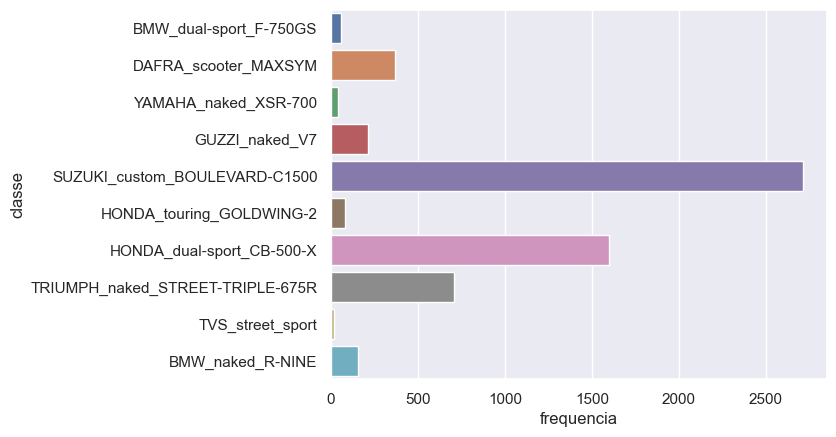

In [4]:
DATA_PATH = Path("../data/")

freq = get_class_freq(DATA_PATH)
sns.barplot(data=freq, x="frequencia", y="classe")
plt.show()

Percebemos que a distribuição dos dados de treino por classe estão desbalanceados.

## Pesos para as classes

# Data loading

Em primeiro lugar, precisamos prepara nossos dados de uma forma que eles sejam facilmente consumíveis pelo nosso modelo. Para isso, vou utilizar as funções de `datapipe` do pacote `torchdata` do PyTorch e, do mesmo pacote, vou utilizar `dataloader2` que será responsável pelo carregamento das imagens em batches para o modelo.

## Data Pipe

Aqui crio a pipeline de transformação e carregamento dos dados. Os dados são carregados diretamente do link do google drive, mantendo o arquivo ainda salvo em disco durante o treinamento.

In [5]:
def path_to_label(item):
    return label_mapping[Path(item).parent.name]


def path_func(path):
    temp_dir = Path("../temp/")
    return str(temp_dir / Path(path).name)


def filter_imgs(file: tuple[str, Image.Image]):
    return file.endswith((".jpg", ".png"))


def image_encoder_to_tensor(example):
    return TF.PILToTensor()(Image.open(BytesIO(example)))

In [6]:
def url_pipe(
    url: str,
    N_images: int,
    seed: int,
    split: float,
    transform: TF.Compose,
    batch_size: int = 32,
    cache_size: int = 1024,
) -> tuple[idp.IterDataPipe, idp.IterDataPipe]:
    IMAGEM_IDX = 1
    LABEL_IDX = 0

    # link para o arquivo no gdrive
    url_wrapper = idp.IterableWrapper([url])

    # cache do dataset em disco
    disk_cache = (
        url_wrapper.on_disk_cache(filepath_fn=path_func)
        .read_from_gdrive()
        .end_caching(same_filepath_fn=True)
    )

    data_pipe = (
        disk_cache.open_files(mode="rb")
        .load_from_zip()
        .filter(filter_fn=filter_imgs, input_col=LABEL_IDX)
        .map(path_to_label, input_col=LABEL_IDX, output_col=LABEL_IDX)
        .read_from_stream()
        .map(image_encoder_to_tensor, input_col=IMAGEM_IDX, output_col=IMAGEM_IDX)
    )

    if transform:
        data_pipe = data_pipe.map(
            transform, input_col=IMAGEM_IDX, output_col=IMAGEM_IDX
        )

    data_pipe = (
        data_pipe.shuffle()
        .prefetch(batch_size)
        .batch(batch_size=batch_size, drop_last=True)
        .collate()
    )

    split_dict = {"train": split, "valid": 1 - split}
    train, valid = data_pipe.random_split(
        weights=split_dict, total_length=N_images, seed=seed
    )

    mapped_cached_train = train.in_memory_cache(cache_size)
    mapped_cached_valid = valid.in_memory_cache(cache_size)

    return mapped_cached_train, mapped_cached_valid

In [7]:
def file_pipe(
    file: Path | str,
    N_images: int,
    seed: int,
    split: float,
    transform: TF.Compose,
    batch_size: int = 32,
    cache_size: int = 1024,
) -> tuple[idp.IterDataPipe, idp.IterDataPipe]:
    IMAGEM_IDX = 1
    LABEL_IDX = 0

    # link para o arquivo no gdrive
    files = idp.FileLister(file, recursive=True, masks=["**.jpg", "**.png"])

    data_pipe = (
        files.open_files(mode="rb")
        .map(path_to_label, input_col=LABEL_IDX, output_col=LABEL_IDX)
        .read_from_stream()
        .map(image_encoder_to_tensor, input_col=IMAGEM_IDX, output_col=IMAGEM_IDX)
    )

    if transform:
        data_pipe = data_pipe.map(
            transform, input_col=IMAGEM_IDX, output_col=IMAGEM_IDX
        )

    data_pipe = (
        data_pipe.shuffle()
        .prefetch(batch_size)
        .batch(batch_size=batch_size, drop_last=True)
        .collate()
        .in_memory_cache(cache_size)
    )

    split_dict = {"train": split, "valid": 1 - split}
    train, valid = data_pipe.random_split(
        weights=split_dict, total_length=N_images, seed=seed
    )

    return train, valid

# Modelo

Para a arquitetura da rede, decidi por utilizar a `resnet18` por obter boa performance de classificação sem ser ocupar tanto espeço em memória com resnets maiores, além de manter o tempo de inferência mais baixo.

Vou realizar uma implementação de fine-tuning da `resnet18` pré treinado fornecida no `Torch Hub` e treinamento do zero da rede para comparar o esforço, performance e tempo de computação necessário para cada implementação.

## Pré-processamento

Redes ResNet esperam imagens de entrada com algumas características específicas:

1. Tamanho da imagem deve ser no mínimo 224x224
2. Pixels com valores entre 0 e 1
3. Normalizadas com valoras para RGB para médias e desvio padrão iguais a: `mean = [0.485, 0.456, 0.406]` e `std = [0.229, 0.224, 0.225]`

podemos obter essas transformações diretamente de `ResNet18_Weights` ou montá-las manualmente como a seguir:

```
preproc_func = TF.Compose(
[
    TF.Resize(256),
    TF.CenterCrop(224),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
)   
```

Utilizo a transformação fornecida pelo Pytorch por simplicidade. Aqui também crio a pipeline de transformação dos dados e o dataloader.

## Pré-treinado com fine-tuning

# Treinamento

In [8]:
def label_to_vector(label: int, n_classes: int):
    # tensor com somente 1 na posicao correspondente ao label
    mask = torch.range(1, n_classes) == label

    return (torch.ones_like(mask) * mask).type(torch.float)


label_to_vector(6, 10)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [9]:
def train_epoch(
    model: nn.Module,
    optimizer,
    criterion: nn.Module,
    data_loader: dl2.DataLoader2,
    device: torch.DeviceObjType,
    metrics: tmetrics.MetricCollection,
    epoch: int,
    tboard_writer: tboard.SummaryWriter,
    batch_size: int,
    n_batches: int,
) -> float:
    # modelo em modo de treinamento
    model.train()

    n_classes = list(model.fc.children())[0].out_features

    running_loss = 0.0

    iterator = tqdm(
        enumerate(data_loader),
        desc="train batches",
        total=n_batches,
        unit="batches",
        postfix={"running_loss": running_loss},
        position=1,
        leave=False,
    )

    for i, (labels, imgs) in iterator:
        labels = torch.stack(
            [label_to_vector(label, n_classes) for label in labels]
        ).to(device)

        imgs = imgs.to(device)

        # zerando gradientes da ultima atualizacao
        optimizer.zero_grad()

        # forward pass
        outputs = torch.round(model(imgs))
        loss = criterion(outputs, labels)

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

        # logging
        running_loss += float(loss)

        n_iter = (epoch * n_batches) + i
        tboard_writer.add_scalar(
            "train/batch/loss", float(loss), n_iter, new_style=True
        )
        tboard_writer.add_scalars("train/batch/", metrics(outputs, labels), n_iter)

        metrics.update(
            outputs,
            labels,
        )

        iterator.set_postfix({"running_loss": running_loss})

    # logging
    tboard_writer.add_scalars(
        main_tag=("train/epoch/"),
        tag_scalar_dict=metrics.compute(),
        global_step=epoch,
    )
    metrics.reset()
    tboard_writer.add_scalar("train/epoch/loss", running_loss, epoch, new_style=True)
    tboard_writer.flush()

    return running_loss

In [10]:
def eval(
    model: nn.Module,
    criterion: nn.Module,
    data_loader: dl2.DataLoader2,
    device: torch.DeviceObjType,
    metrics: tmetrics.MetricCollection,
    epoch: int,
    tboard_writer: tboard.SummaryWriter,
    batch_size: int,
    n_batches: int,
) -> float:
    # modelo em modo de validacao
    model.eval()

    n_classes = list(model.fc.children())[0].out_features

    # equivalente a nograd
    running_loss = 0.0
    with torch.inference_mode():
        iterator = tqdm(
            enumerate(data_loader),
            desc="val batches",
            total=n_batches,
            unit="batches",
            postfix={"running_loss": running_loss},
            position=1,
            leave=False,
        )

        for i, (labels, imgs) in iterator:
            labels = torch.stack(
                [label_to_vector(label, n_classes) for label in labels]
            ).to(device)
            imgs = imgs.to(device)

            labels = labels.to(device)
            imgs = imgs.to(device)

            # forward pass
            outputs = torch.round(model(imgs))

            # erro
            loss = criterion(outputs, labels)
            running_loss += float(loss)

            n_iter = (epoch * n_batches) + i
            tboard_writer.add_scalar("eval/batch/loss", float(loss), n_iter)
            tboard_writer.add_scalars(
                "eval/batch/",
                metrics(outputs, labels),
                n_iter,
            )

            iterator.set_postfix({"running_loss": running_loss})

    # logging
    tboard_writer.add_scalars("eval/epoch/", metrics.compute(), epoch)
    metrics.reset()

    tboard_writer.add_scalar("eval/epoch/loss", running_loss, epoch)

    tboard_writer.flush()
    return running_loss

In [11]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: dl2.DataLoader2,
    val_loader: dl2.DataLoader2,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    device: torch.DeviceObjType,
    N_epochs: int,
    train_metrics: tmetrics.MetricCollection,
    val_metrics: tmetrics.MetricCollection,
    writer: tboard.SummaryWriter,
    batch_size: int,
    n_train_batches: int,
    n_val_batches: int,
):
    train_loss = eval_loss = lr = 0.0

    pbar = trange(
        N_epochs,
        desc="Epocas",
        unit="epochs",
        postfix={"train_loss": train_loss, "eval_loss": eval_loss, "learning_rate": lr},
        position=0,
    )
    for epoch in pbar:
        train_loss = train_epoch(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            data_loader=train_loader,
            device=device,
            epoch=epoch,
            metrics=train_metrics,
            tboard_writer=writer,
            batch_size=batch_size,
            n_batches=n_train_batches,
        )

        lr_scheduler.step()
        lr = lr_scheduler.get_last_lr()

        eval_loss = eval(
            model=model,
            criterion=criterion,
            data_loader=val_loader,
            device=device,
            metrics=val_metrics,
            epoch=epoch,
            tboard_writer=writer,
            batch_size=batch_size,
            n_batches=n_val_batches,
        )

        pbar.set_postfix(
            {"train_loss": train_loss, "eval_loss": eval_loss, "learning_rate": lr}
        )

    train_loader.shutdown()
    val_loader.shutdown()

    writer.close()

## Constantes e hiperparâmetros

In [12]:
# instanciando os pesos do modelo e a funcao de pre-processamento
weights = ResNet18_Weights.DEFAULT
preproc_transforms = weights.transforms()


# criando pipelines de treinamento e validacao
train_pipe, val_pipe = file_pipe(
    file=str(DATA_PATH),
    N_images=N_IMAGENS,
    seed=SEED,
    split=SPLIT,
    transform=preproc_transforms,
    batch_size=BATCH_SIZE,
    cache_size=MAX_CACHE_SIZE,
)

reading_service = dl2.MultiProcessingReadingService()
train_loader = dl2.DataLoader2(datapipe=train_pipe, reading_service=reading_service)
val_loader = dl2.DataLoader2(datapipe=val_pipe, reading_service=reading_service)

Para realizarmos o fine-tuning, precisamos modificar o ultimo layer `fc` para ter o número de classes do nosso problema como saida.

In [13]:
model = resnet18(weights=weights)

# mudando tamanho de saida da ultima camada
new_input = model.fc.in_features


last_layer = nn.Sequential(nn.Linear(in_features=new_input, out_features=N_CLASSES))
model.fc = last_layer

exp_name = datetime.now().strftime("%m:%d-%H:%M")
# writes para vermos estatisticas no tensorboard
writer = tboard.SummaryWriter(log_dir=(LOG_PATH / exp_name))

example = next(iter(train_loader))

writer.add_graph(model, example[1])

model = model.to(DEVICE)

In [14]:
# optimizer

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params=params, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=LR_STEP, gamma=GAMMA
)

criterion = nn.CrossEntropyLoss().to(DEVICE)

train_metrics = (
    tmetrics.MetricCollection(
        [
            cmetrics.MulticlassAccuracy(num_classes=N_CLASSES).to(DEVICE),
            cmetrics.MulticlassFBetaScore(beta=F_BETA, num_classes=N_CLASSES).to(
                DEVICE
            ),
        ]
    )
    .train()
    .to(DEVICE)
)

val_metrics = (
    tmetrics.MetricCollection(
        [
            cmetrics.MulticlassAccuracy(num_classes=N_CLASSES).to(DEVICE),
            cmetrics.MulticlassFBetaScore(beta=F_BETA, num_classes=N_CLASSES).to(
                DEVICE
            ),
        ]
    )
    .eval()
    .to(DEVICE)
)


train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    lr_scheduler=lr_scheduler,
    device=DEVICE,
    N_epochs=N_EPOCHS,
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    writer=writer,
    batch_size=BATCH_SIZE,
    n_train_batches=((N_IMAGENS * SPLIT) // BATCH_SIZE),
    n_val_batches=((N_IMAGENS * (1 - SPLIT)) // BATCH_SIZE),
)

# jit nao tem suporte para device "mps" do mac, retornamos o modelo para o cpu
model.to(torch.device("cpu"))
trained_model = torch.jit.script(model)
trained_model.save(MODELS_PATH)

Epocas:   0%|          | 0/100 [00:00<?, ?epochs/s, eval_loss=0, learning_rate=0, train_loss=0]

train batches:   0%|          | 0/18.0 [00:00<?, ?batches/s, running_loss=0]

val batches:   0%|          | 0/4.0 [00:00<?, ?batches/s, running_loss=0]

# Inferencia

In [ ]:
def inference(model_path, test_img):
    # carregando modelo
    loaded_model = torch.jit.load("../models/model.pt")
    loaded_model.eval()

    # imagem para teste
    # ifuncao de pre-processamento
    weights = ResNet18_Weights.DEFAULT
    preproc_transforms = weights.transforms()

    test_img = preproc_transforms(test_img)

    return label_mapping.keys(torch.argmax(loaded_model(test_img)))

# References

[1] <https://doi.org/10.48550/arXiv.1704.04861> "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications"

[2] <https://doi.org/10.48550/arXiv.1512.03385> "Deep Residual Learning for Image Recognition"

[3] <https://en.wikipedia.org/wiki/Accuracy_paradox#:~:text=The%20accuracy%20paradox%20is%20the,too%20crude%20to%20be%20useful.> "Accuracy Paradox"